# Imports

In [4]:
import hoomd

In [22]:
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)
import matplotlib.pyplot as plt

# Autocorrelation

In [6]:
def autocorr1D(array):
    """Takes in a linear np array, performs autocorrelation
    function and returns normalized array with half the length
    of the input.

    Parameters
    ----------
    data : numpy.typing.Arraylike, required
        1-D series of data to perform autocorrelation on.

    Returns
    -------
    1D np.array

    """
    ft = numpy.fft.rfft(array - numpy.average(array))
    acorr = numpy.fft.irfft(ft * numpy.conjugate(ft)) / (len(array) * numpy.var(array))
    return acorr[0 : len(acorr) // 2]  # noqa: E203

# Heat Capacity

In [106]:
def heat_capacity(energies,temp):
    mean_energy = numpy.mean(energies)
    mean_energy_squared = numpy.mean(numpy.array(energies)**2)
    k_B = 1.0
    E_var = numpy.var(energies)
    C_V_error = numpy.sqrt(E_var / len(energies)) / (k_B * numpy.mean(temp)**2)
    C_V = (mean_energy_squared - mean_energy**2) / (temp**2 * k_B)
    return C_V, C_V_error

# RDF

In [43]:
def rdf(positions, density, r_max=3.0, bin_width=0.02):
    
    N = len(positions)
    volume = N/density
    Lx, Ly, Lz = volume**(1/3),volume**(1/3),volume**(1/3)
    
    num_bins = int(r_max / bin_width)
    rdf_hist = numpy.zeros(num_bins)


    for i in range(N):
        for j in range(i + 1, N):
            dr = positions[i] - positions[j]

            dr[0] -= Lx * numpy.round(dr[0] / Lx)
            dr[1] -= Ly * numpy.round(dr[1] / Ly)
            dr[2] -= Lz * numpy.round(dr[2] / Lz)

            r = numpy.linalg.norm(dr)
            if r < r_max:
                bin_index = int(r / bin_width)
                rdf_hist[bin_index] += 2 

    r = numpy.linspace(0.5 * bin_width, r_max - 0.5 * bin_width, num_bins)
    shell_volumes = (4/3) * numpy.pi * ((r + 0.5 * bin_width)**3 - (r - 0.5 * bin_width)**3)
    ideal_counts = density * shell_volumes * N
    g_r = rdf_hist / ideal_counts

    return r, g_r

In [11]:
epsilon = 1.0
sigma = 1.0

# Inital Configurations

In [58]:
import freud
starting_density = 0.5
#a is the spacing between particles
a = 1/(starting_density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 1
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx
print(box_length)

34.01786804199219


In [59]:
import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state_10.gsd', mode='w') as f:
    f.append(frame)

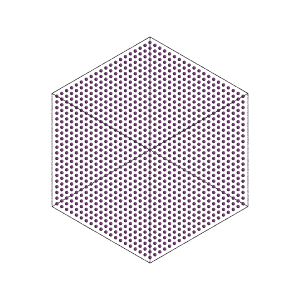

In [7]:
from cmeutils.visualize import FresnelGSD

sim_visualizer = FresnelGSD(
    gsd_file="initial_state.gsd", frame=0, view_axis=(1, 1, 1)
)
sim_visualizer.view()

# Temperature Simulations

In [212]:
dt = 0.005
epsilon = 1.0
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
pe_temp_runs = {}
ke_temp_runs = {}
positions = {}
for i in T:
  del simulation
  print(i)
  pe_temp_runs[f"{i}"] = []
  ke_temp_runs[f"{i}"] = []
  positions[f"{i}"] = []
  seed = numpy.random.randint(1,1e4)
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_12.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=i,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=i)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure','volume'])
  gsd_writer = hoomd.write.GSD(filename='projectdata/log_T_'+str(i)+'_N_12.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')
  simulation.operations.writers.append(gsd_writer)
  gsd_writer.log = logger
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
    simulation.run(10)
    pe_temp_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
    ke_temp_runs[f"{i}"].append(thermodynamic_properties.kinetic_energy)
  ind_samples = 0
  total_steps = 10000
  print(len(pe_temp_runs[f"{i}"]))
  while ind_samples < 20:
      a = autocorr1D(pe_temp_runs[f"{i}"][1000:])# cutting off approx. inital relaxation
      decorrelation_time = numpy.where(a <= 0)[0][0]
      ind_samples = (total_steps)/decorrelation_time
      print("independent samples: ", ind_samples)
      if ind_samples >= 20:
          break
      for step in range(10000):
        simulation.run(10)
        pe_temp_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
        ke_temp_runs[f"{i}"].append(thermodynamic_properties.kinetic_energy)
      total_steps += 10000
      print(total_steps)
  snapshot = simulation.state.get_snapshot()
  positions[f"{i}"].append(snapshot.particles.position)

0.5
Simulation.timestep  Simulation.tps 
       10000           893.21159    
       20000           1633.69032   
       30000           889.06451    
       40000           873.78641    
       50000           876.68030    
       60000           1628.36982   
       70000           865.96748    
       80000           877.27849    
       90000           890.56006    
      100000           850.01889    
10000
independent samples:  9.285051067780874
      110000           890.03165    
      120000           1542.94531   
      130000           888.62559    
      140000           1597.72768   
      150000           1544.79918   
      160000           874.97570    
      170000           872.26207    
      180000           1595.46180   
      190000           1442.30769   
      200000           1597.44409   
20000
independent samples:  17.77777777777778
      210000           883.21884    
      220000           868.47438    
      230000           1613.19233   
      240000    

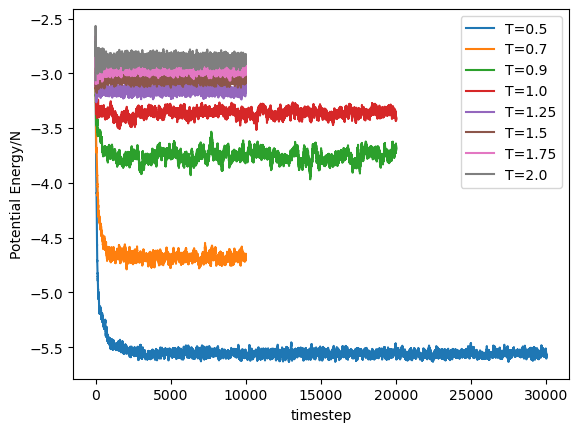

In [225]:
import matplotlib.pyplot as plt
for T, e in pe_temp_runs.items():
  plt.plot(numpy.array(e[:])/1728, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy/N')
plt.legend()

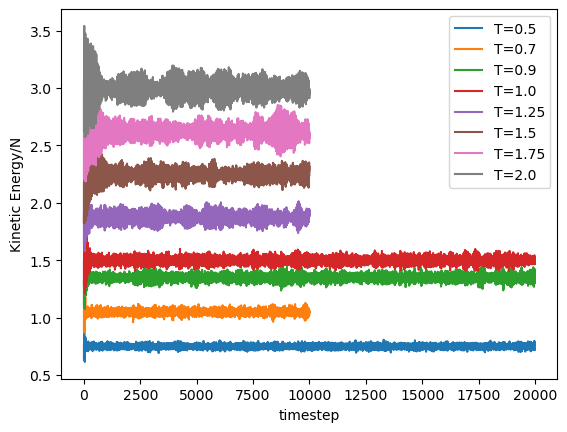

In [226]:
for T, e in ke_temp_runs.items():
  plt.plot(numpy.array(e[:20000])/1728, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Kinetic Energy/N')
plt.legend()

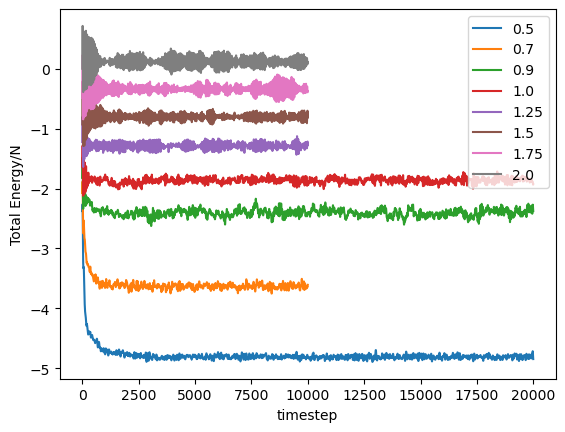

In [227]:
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
for kT in T:
    total_energy = numpy.array(pe_temp_runs[f"{kT}"])+numpy.array(ke_temp_runs[f"{kT}"])
    plt.plot(total_energy[:20000]/1728,label=kT)
plt.xlabel('timestep')
plt.ylabel('Total Energy/N')
plt.legend()

0.5
0.7
0.9
1.0
1.25
1.5
1.75
2.0


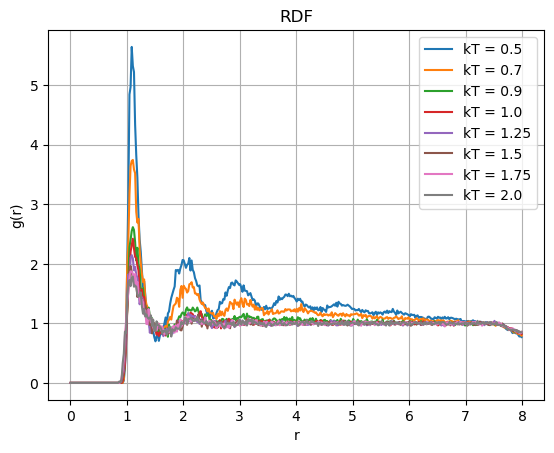

In [236]:
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
for kT in T:
    print(kT)
    snapshot = positions[f"{kT}"]
    r, g_r = rdf(snapshot[0], density=0.5,r_max=8.0)
    plt.plot(r,g_r, label=f"kT = {kT}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF")
plt.legend()
plt.grid(True)

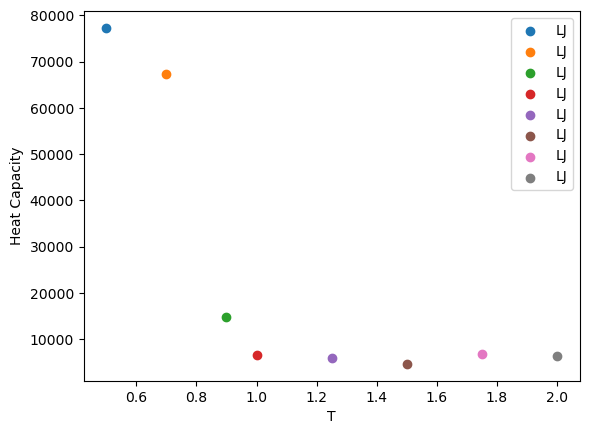

In [234]:
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
for i in T:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_T_'+str(i)+'_N_12.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy,temp=i)
    plt.scatter(i,heatcapacity,label='LJ')
    plt.errorbar(i,heatcapacity, yerr=error)

plt.xlabel('T')
plt.ylabel('Heat Capacity')
plt.legend()

# Model Behaviour Analysis

## Above what temperature is your system “hot”? How do you know?
## Below what temperature is your system “frozen”? How do you know?

    Without visualizing the system, you can use the radial distribution function to analyze how the particle neighbor distance varies with cutoff radius. I would say that below 0.6 kT, the system is frozen because it has the feature peaks of a crystal (greater intensity fluctuations). At and below 0.5 kT, I was observing that the system was relaxing very slowly. Above 1.0 kT follows the RDF of a liquid phase. I would consider at and above 1.0kT to be "hot". The energy of the systems above 1.0 kT relax quickly to an equillibrium state, indicating a "hot" system. The longest relaxation time was ~8000 steps for 0.5 kT and the shortest for 2.0kT was ~1500 steps. This is observed from the graphs of total energy.
    
## How does the system’s total energy, potential energy, kinetic energy, heat capacity, and structure vary from frozen to too hot?

    For each type of energy, the higher temperatures have more variation(fluctuations). In the total energy, you can see this variation primarily at the beginning and then the system relaxing to lower variations after it has equillibrated. The heat capacity shows phase transitions around 0.5kT, 0.8kT and 1.0kT. At a temperature >1.0kT the heat capacity is stable. The heat capacity of the frozen system is the highest.

# Finite Size Effects

In [214]:
N = [5,10,12,20,25]
dt = 0.005
T = 0.7
pe_N_runs = {}
ke_N_runs = {}
positions_N = {}
for i in N:
  del simulation
  print(i)
  pe_N_runs[f"{i}"] = []
  ke_N_runs[f"{i}"] = []
  positions_N[f"{i}"] = []
  seed = numpy.random.randint(1,1e4)
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_'+str(i)+'.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=T,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=T)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure','volume'])
  gsd_writer = hoomd.write.GSD(filename='projectdata/log_finite_T_0.7_N_'+str(i)+'_reruns.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')
  simulation.operations.writers.append(gsd_writer)
  gsd_writer.log = logger
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
    simulation.run(10)
    pe_N_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
  ind_samples = 0
  total_steps = 10000
  print(len(pe_N_runs[f"{i}"]))
  while ind_samples < 20:
      a = autocorr1D(pe_N_runs[f"{i}"][1000:])
      decorrelation_time = numpy.where(a <= 0)[0][0]
      ind_samples = (total_steps)/decorrelation_time
      print("independent samples: ", ind_samples)
      if ind_samples >= 20:
          break
      for step in range(10000):
        simulation.run(10)
        pe_N_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
      total_steps += 10000
      print(total_steps)
  snapshot = simulation.state.get_snapshot()
  positions_N[f"{i}"].append(snapshot.particles.position)

5
Simulation.timestep  Simulation.tps 
       10000          41284.40367   
       20000          20454.54545   
       30000          39647.57709   
       40000          19522.77657   
       50000          19823.78855   
       60000          19867.54967   
       70000          20134.22819   
       80000          20833.33333   
       90000          39473.68421   
      100000          38961.03896   
10000
independent samples:  113.63636363636364
10
Simulation.timestep  Simulation.tps 
       10000           1674.41860   
       20000           1718.21306   
       30000           1678.79127   
       40000           1729.43889   
       50000           1670.06866   
       60000           1671.61961   
       70000           1700.03778   
       80000           1685.70893   
       90000           1687.92198   
      100000           3396.22642   
10000
independent samples:  185.1851851851852
12
Simulation.timestep  Simulation.tps 
       10000           950.36959    
       2000

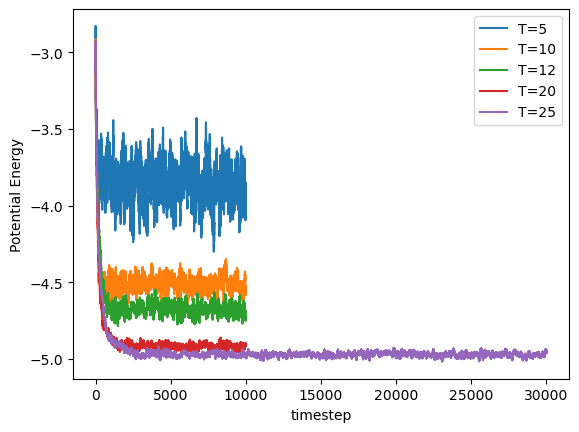

In [215]:
import matplotlib.pyplot as plt
N = [5,10,12,20,25]
for N, e in pe_N_runs.items():
  plt.plot(numpy.array(e[:])/(int(N)**3), label=f'T={N}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


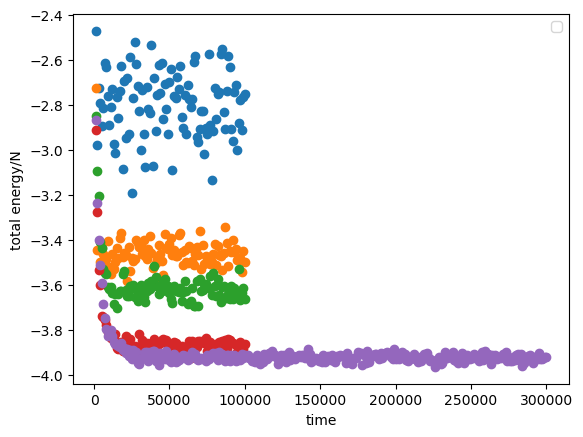

In [221]:
N = [5,10,12,20,25]
for i in N:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_finite_T_0.7_N_'+str(i)+'_reruns.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
        time.append(traj[frame].log['Simulation/timestep'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    plt.scatter(time,total_energy/int(i**3))
plt.xlabel('time')
plt.ylabel('total energy/N')
plt.legend()

5
10
12
20


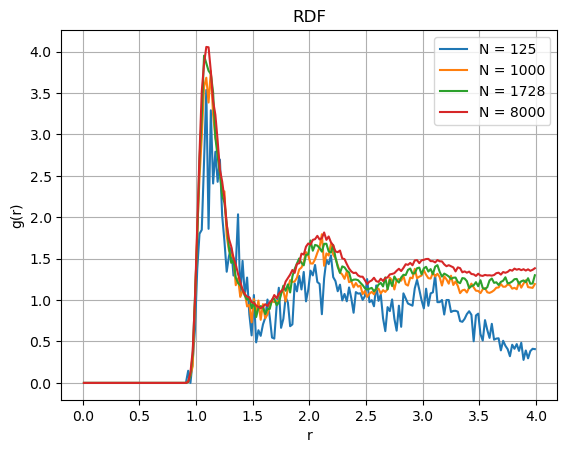

In [241]:
T = 0.7
N = [5,10,12,20]
for i in N:
    print(i)
    snapshot = positions_N[f"{i}"]
    r, g_r = rdf(snapshot[0], density=0.5,r_max=4.0)
    plt.plot(r,g_r, label=f"N = {i**3}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF")
plt.legend()
plt.grid(True)

-3.863632448777595
-4.511298939636955
-4.678772813169753
-4.919927010028156
-4.971434387359638


Text(0, 0.5, 'avg(PE)/N')

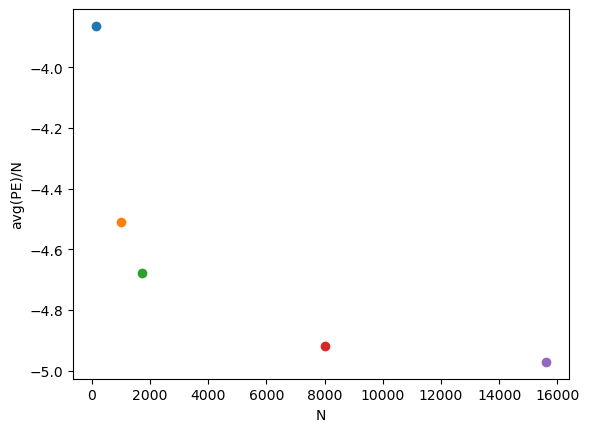

In [222]:
import matplotlib.pyplot as plt
N = [5,10,12,20,25]
for N, e in pe_N_runs.items():
  print(numpy.mean(e[5000:])/(int(N)**3))
  plt.scatter(int(N)**3,numpy.mean(e[5000:])/(int(N)**3))
plt.xlabel('N')
plt.ylabel('avg(PE)/N')

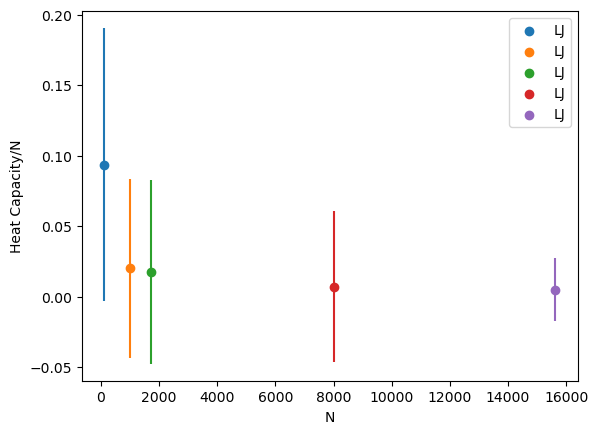

In [223]:
N = [5,10,12,20,25]
for i in N:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_finite_T_0.7_N_'+str(i)+'_reruns.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy[50:],temp=i) #adding cut for relaxation time
    plt.scatter(i**3,heatcapacity/(i**3),label='LJ')
    plt.errorbar(i**3,heatcapacity/(i**3), yerr=error)

plt.xlabel('N')
plt.ylabel('Heat Capacity/N')
plt.legend()

# Finite Size Effect Analysis
## How small is too small to be correct? How large is too large to be practical?
    Less than 1000 particles appears to be the cutoff of too small. This is where the graph begins to get exponentially worse(increased avg(PE)) in the energy measurements. Greater than 4,000 particles is impractically large due to the time it takes to run the simulations. This may change depending on the CPU power of the computer being used. I initially ran my temperature state points with 1000 particles, and increased that to 1728 particles after observing these finite size effects. Looking at the heat capacity, there is much more error and variation from the mean value in the system of N = 15,625. Note that for this data point, I ended the simulation after 7 independent samples due to the time it was taking to run. If I had run longer and let the system equillibrate, then the error in heat capacity would likely be decreased. UPDATE: I let the N = 15,625 equillibrate and it significantly reduced the error. With the new graph, I would say between 1000 and 8000 particles is ideal.

# Ideal Gas

In [61]:
epsilon=0 #make interactions for LJ forcefield 0 to model an ideal gas
dt = 0.005
T = [0.5,0.8,1.0,1.5,2.0]
pe_ideal_runs = {}
ke_ideal_runs = {}
positions_ideal = {}
for i in T:
  del simulation
  print(i)
  pe_ideal_runs[f"{i}"] = []
  ke_temp_runs[f"{i}"] = []
  positions_ideal[f"{i}"] = []
  seed = numpy.random.randint(1,1e4)
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_10.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=i,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=i)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure','volume'])
  gsd_writer = hoomd.write.GSD(filename='projectdata/log__ideal_T_'+str(i)+'_N_10.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')
  simulation.operations.writers.append(gsd_writer)
  gsd_writer.log = logger
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
    simulation.run(10)
    pe_ideal_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
  snapshot = simulation.state.get_snapshot()
  positions_ideal[f"{i}"].append(snapshot.particles.position)

0.5
Simulation.timestep  Simulation.tps 
       10000           2249.43764   
       20000           5431.50272   
       30000           2274.45034   
       40000           5924.95063   
       50000           2212.38938   
       60000           5481.12058   
       70000           5703.42205   
       80000           5674.65322   
       90000           5836.57588   
      100000           5481.12058   
0.8
Simulation.timestep  Simulation.tps 
       10000           2188.18381   
       20000           2188.71595   
       30000           2151.56586   
       40000           2174.43827   
       50000           2195.12195   
       60000           5099.15014   
       70000           2170.24355   
       80000           2180.23256   
       90000           2161.90247   
      100000           2199.95111   
1.0
Simulation.timestep  Simulation.tps 
       10000           2190.31394   
       20000           2137.25956   
       30000           2171.29071   
       40000           213

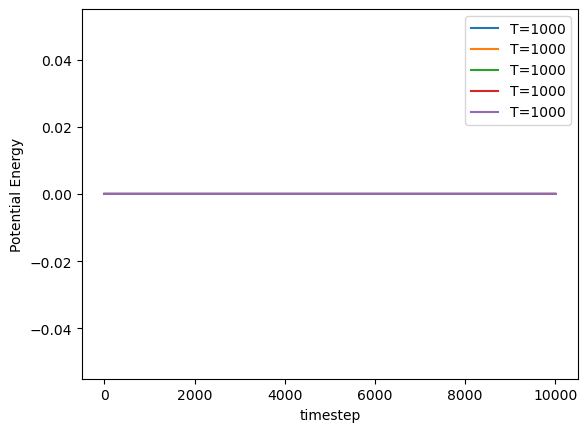

In [224]:
import matplotlib.pyplot as plt
T = [0.5,0.8,1.0,1.5,2.0]
N=1000
for T, e in pe_ideal_runs.items():
  plt.plot(numpy.array(e[:])/(int(N)**3), label=f'T={N}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy')
plt.legend()

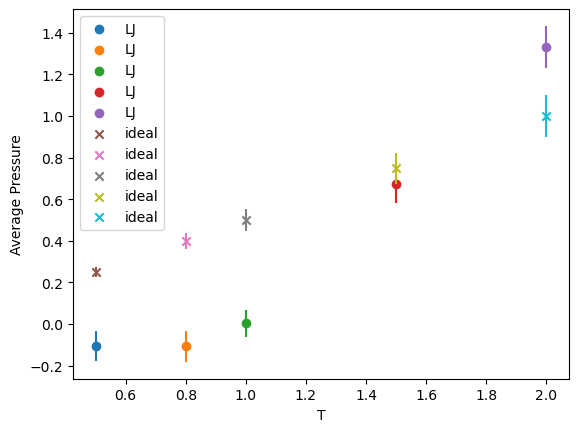

In [100]:
T = [0.5,0.8,1.0,1.5,2.0]
for i in T:
    pressure_LJ = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        pressure_LJ.append(traj[frame].log['md/compute/ThermodynamicQuantities/pressure'][0])
        time.append(traj[frame].log['Simulation/timestep'][0])        
    plt.scatter(i,numpy.mean(pressure_LJ),label='LJ')
    plt.errorbar(i,numpy.mean(pressure_LJ), yerr=numpy.std(pressure_LJ))
for i in T:
    pressure_ideal = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log__ideal_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        pressure_ideal.append(traj[frame].log['md/compute/ThermodynamicQuantities/pressure'][0])
        time.append(traj[frame].log['Simulation/timestep'][0])        
    plt.scatter(i,numpy.mean(pressure_ideal),marker='x',label='ideal')
    plt.errorbar(i,numpy.mean(pressure_ideal), yerr=numpy.std(pressure_ideal))

plt.xlabel('T')
plt.ylabel('Average Pressure')
plt.legend()

0.5
0.8
1.0
1.5
2.0


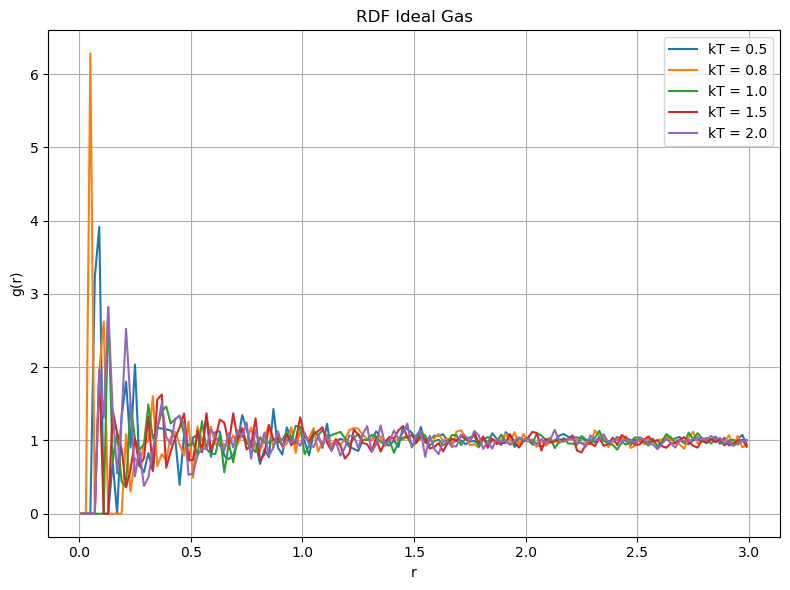

In [63]:
T = [0.5,0.8,1.0,1.5,2.0]
plt.figure(figsize=(8, 6))
for kT in T:
    print(kT)
    snapshot = positions_ideal[f"{kT}"]
    r, g_r = rdf(snapshot[0], density=0.5)
    plt.plot(r,g_r, label=f"kT = {kT}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("RDF Ideal Gas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

30.039145841062822
18.775770899047295
15.348330438196077
10.02343115876202
7.652327623828938


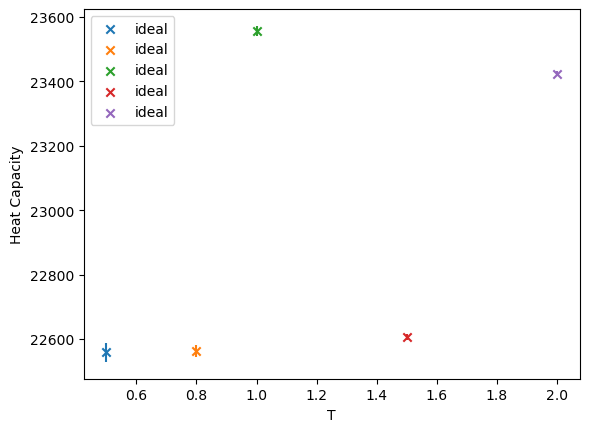

In [122]:
T = [0.5,0.8,1.0,1.5,2.0]
'''for i in T:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy,temp=i)
    plt.scatter(i,heatcapacity,label='LJ')
    plt.errorbar(i,heatcapacity, yerr=error)'''
for i in T:
    kinetic = []
    potential = []
    time=[]
    traj = gsd.hoomd.open('projectdata/log__ideal_T_'+str(i)+'_N_10.gsd', 'r')
    for frame in range(len(traj)):
        kinetic.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
        potential.append(traj[frame].log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    kinetic_array = numpy.array(kinetic)
    potential_array = numpy.array(potential)
    total_energy = kinetic_array+potential_array
    heatcapacity, error = heat_capacity(energies=total_energy,temp=i)
    print(error)
    plt.scatter(i,heatcapacity,label='ideal',marker = 'x')
    plt.errorbar(i,heatcapacity, yerr=error)
plt.xlabel('T')
plt.ylabel('Heat Capacity')
plt.legend()

Text(0, 0.5, 'Virial Coefficient')

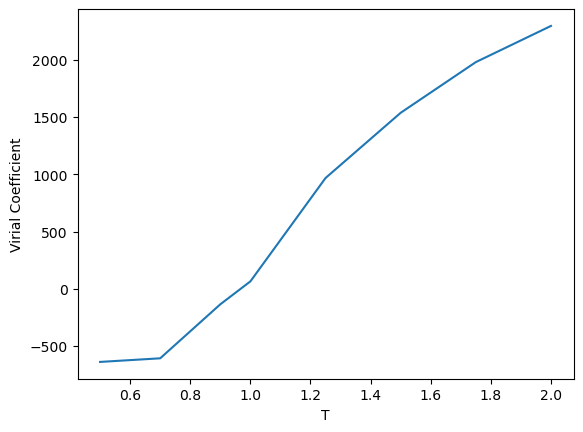

In [191]:
T = [0.5,0.7,0.9,1.0,1.25,1.5,1.75,2.0]
virial_coeff = []
for i in T:
    pressure_LJ = []
    volume = []
    kinetic_temp=[]
    traj = gsd.hoomd.open('projectdata/log_T_'+str(i)+'_N_10_reruns.gsd', 'r')
    for frame in range(len(traj)):
        pressure_LJ.append(traj[frame].log['md/compute/ThermodynamicQuantities/pressure'][0])
        volume.append(traj[frame].log['md/compute/ThermodynamicQuantities/volume'][0])
        kinetic_temp.append(traj[frame].log['md/compute/ThermodynamicQuantities/kinetic_temperature'][0])
    virial_coeff.append(numpy.mean(volume) * numpy.mean(pressure_LJ) / numpy.mean(kinetic_temp) - 1 / numpy.mean(volume))
plt.plot(T,virial_coeff)
plt.xlabel('T')
plt.ylabel('Virial Coefficient')

# Analysis of an Ideal Gas
## How does the structure of your model vary with state, and how does it compare to particles with no interactions?
    Looking at the RDF and the heat capacity of the ideal gas system, they are both random. There is no correlation between distance of particles or energy fluctuations. This is due to there being no force driving interactions or ordering of the system. 
## Does the heat capacity of your system depend on state differently than an ideal gas?
    Yes. Above I have graphed pressure vs. temperature of the LJ system and an ideal gas with LJ interactions set to 0. The ideal gas scales linearly, which we would expect from the ideal gas law. The LJ system appear to scale parabollically (exponentially).
## Can you derive or numerically determine an equation of state?
    I attempted to derive an equation of state using the virial sum. I found the virial coefficient for each LJ temperature simulation and graphed that against temperature.

# Summary
    This project on molecular dynamics required a level up on data and file handling. I spent the bulk of my time on this project learning how to log simulation properties and how to save simulations to a gsd file. I spent time on this so that I could run large systems without losing data. With my first set of temperature run simulations, I ran into some errors with the kinetic energy having a different log frequency from the potential energy. One of the thermodynamic properties I chose to log was pressure. If I had more time, I would look into how this was being calculated and if this is the correct pressure to monitor. I would also include a measurement for relaxation time or equillibration with more time spent on this project. I included a calculation of the decorrelation time and ensured that all of my simulations had at least 20 independant samples. I tried to include a measurement of precision for the heat capacity under each section. For the heat capacity, the standard error was calculated from the variance of the energy and considered the size of the sample. In the last section on ideal gases I also included standard error of the average pressure. With more time and more computing power, I would run multiple simulations with the same parameters and different seeds to get statistical information on the sampling. The most interesting part of this project was the finite size effects for the system. I initally thought running with 1000 particles would be well beyond the finite size effects but my graph indicated a higher number of particles was needed. I'm a little confused with this measurement because the system sizes I have been running for research are a lower number of particles. 